In [0]:
import pyspark
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('carbon_emission_model').getOrCreate()
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/gamedishant@gmail.com/Data__1_-2.csv")

In [0]:
df.show(10)


+----+--------------------------------------+
|Year|CO2 emissions (metric tons per capita)|
+----+--------------------------------------+
|1961|                           0.616879281|
|1962|                           0.750243117|
|1963|                           0.767637944|
|1964|                           0.870789887|
|1965|                           0.884280713|
|1966|                            0.99463063|
|1967|                           1.032197801|
|1968|                           1.091947115|
|1969|                            1.13955118|
|1970|                           1.222603341|
+----+--------------------------------------+
only showing top 10 rows



In [0]:
df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- CO2 emissions (metric tons per capita): string (nullable = true)



In [0]:
df.columns

Out[36]: ['Year', 'CO2 emissions (metric tons per capita)']

In [0]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

df= df.withColumn("Year", df["Year"].cast(IntegerType()))
df= df.withColumn("CO2 emissions (metric tons per capita)", df["CO2 emissions (metric tons per capita)"].cast(FloatType()))

In [0]:
df.select("Year").dtypes

Out[38]: [('Year', 'int')]

In [0]:
df.select("CO2 emissions (metric tons per capita)").dtypes

Out[39]: [('CO2 emissions (metric tons per capita)', 'float')]

In [0]:
df = df.na.drop()
dt_df = df

Out[41]: <AxesSubplot:xlabel='Year', ylabel='CO2 emissions (metric tons per capita)'>

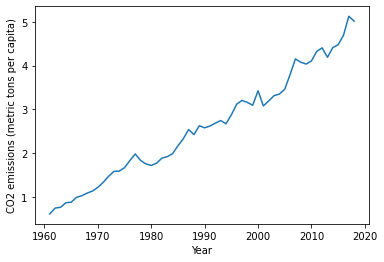

In [0]:
import seaborn as sns
plot_df = df.toPandas()
sns.lineplot(x = "Year", y = "CO2 emissions (metric tons per capita)", data = plot_df)

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler=VectorAssembler(inputCols=['Year'],outputCol='features')
df=assembler.transform(df)
df.select('features','CO2 emissions (metric tons per capita)').show(5)

+--------+--------------------------------------+
|features|CO2 emissions (metric tons per capita)|
+--------+--------------------------------------+
|[1961.0]|                             0.6168793|
|[1962.0]|                             0.7502431|
|[1963.0]|                            0.76763797|
|[1964.0]|                             0.8707899|
|[1965.0]|                            0.88428074|
+--------+--------------------------------------+
only showing top 5 rows



In [0]:
train_data,test_data=df.randomSplit([0.7,0.3])
train_data.describe().show()

+-------+------------------+--------------------------------------+
|summary|              Year|CO2 emissions (metric tons per capita)|
+-------+------------------+--------------------------------------+
|  count|                33|                                    33|
|   mean|1989.8181818181818|                    2.6231089469158286|
| stddev|16.342916174627582|                    1.1832323809832686|
|    min|              1962|                             0.7502431|
|    max|              2017|                              5.127197|
+-------+------------------+--------------------------------------+



In [0]:
train_data.show()

+----+--------------------------------------+--------+
|Year|CO2 emissions (metric tons per capita)|features|
+----+--------------------------------------+--------+
|1962|                             0.7502431|[1962.0]|
|1966|                            0.99463063|[1966.0]|
|1968|                             1.0919471|[1968.0]|
|1969|                             1.1395512|[1969.0]|
|1971|                             1.3362972|[1971.0]|
|1972|                             1.4720211|[1972.0]|
|1974|                             1.5933224|[1974.0]|
|1975|                             1.6726724|[1975.0]|
|1976|                             1.8343412|[1976.0]|
|1977|                               1.98433|[1977.0]|
|1978|                             1.8376876|[1978.0]|
|1980|                             1.7228473|[1980.0]|
|1983|                             1.9234166|[1983.0]|
|1984|                             1.9910295|[1984.0]|
|1985|                             2.1719623|[1985.0]|
|1989|    

In [0]:
test_data.describe().show()

+-------+------------------+--------------------------------------+
|summary|              Year|CO2 emissions (metric tons per capita)|
+-------+------------------+--------------------------------------+
|  count|                25|                                    25|
|   mean|           1989.08|                    2.5884122037887574|
| stddev|17.911634952361776|                    1.3101127162530086|
|    min|              1961|                             0.6168793|
|    max|              2018|                             5.0154185|
+-------+------------------+--------------------------------------+



In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
model_lr = LinearRegression(featuresCol='features',labelCol='CO2 emissions (metric tons per capita)')
trained_model_lr = model_lr.fit(train_data)
model_lr_result = trained_model_lr.evaluate(test_data)

In [0]:
print('Accuracy :', model_lr_result.r2)

Accuracy : 0.98565343785221


In [0]:
df_test = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/gamedishant@gmail.com/predict-1.csv")

In [0]:
df_test.show(5)

+---------+
|test_year|
+---------+
|     2025|
+---------+



In [0]:
df_test.printSchema()

root
 |-- test_year: string (nullable = true)



In [0]:
df_test.columns

Out[54]: ['test_year']

In [0]:
df_test= df_test.withColumn("test_year", df_test["test_year"].cast(IntegerType()))

In [0]:
df_test.select("test_year").dtypes

Out[56]: [('test_year', 'int')]

In [0]:
assembler=VectorAssembler(inputCols=['test_year'],outputCol='features')
df_test=assembler.transform(df_test)

In [0]:
u=df_test.select('features')
u.show(5)

+--------+
|features|
+--------+
|[2025.0]|
+--------+



In [0]:
predictions=trained_model_lr.transform(u)
predictions.show()

+--------+-----------------+
|features|       prediction|
+--------+-----------------+
|[2025.0]|5.137182053276149|
+--------+-----------------+



In [0]:
dt_df.show()

+----+--------------------------------------+
|Year|CO2 emissions (metric tons per capita)|
+----+--------------------------------------+
|1961|                             0.6168793|
|1962|                             0.7502431|
|1963|                            0.76763797|
|1964|                             0.8707899|
|1965|                            0.88428074|
|1966|                            0.99463063|
|1967|                             1.0321978|
|1968|                             1.0919471|
|1969|                             1.1395512|
|1970|                             1.2226033|
|1971|                             1.3362972|
|1972|                             1.4720211|
|1973|                             1.5874667|
|1974|                             1.5933224|
|1975|                             1.6726724|
|1976|                             1.8343412|
|1977|                               1.98433|
|1978|                             1.8376876|
|1979|                            

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
train, test = dt_df.randomSplit([0.7, 0.3])

In [0]:
train.show()

+----+--------------------------------------+
|Year|CO2 emissions (metric tons per capita)|
+----+--------------------------------------+
|1962|                             0.7502431|
|1963|                            0.76763797|
|1964|                             0.8707899|
|1965|                            0.88428074|
|1966|                            0.99463063|
|1968|                             1.0919471|
|1969|                             1.1395512|
|1972|                             1.4720211|
|1973|                             1.5874667|
|1974|                             1.5933224|
|1975|                             1.6726724|
|1976|                             1.8343412|
|1977|                               1.98433|
|1979|                             1.7578452|
|1980|                             1.7228473|
|1981|                             1.7754482|
|1982|                             1.8900119|
|1984|                             1.9910295|
|1985|                            

In [0]:
assembler=VectorAssembler().setInputCols(['Year'],).setOutputCol('Features')
train_a = assembler.transform(train)
train_b=train_a.select("features",train_a['CO2 emissions (metric tons per capita)'].alias('label'))
train_b.show(truncate=False)

+--------+----------+
|features|label     |
+--------+----------+
|[1962.0]|0.7502431 |
|[1963.0]|0.76763797|
|[1964.0]|0.8707899 |
|[1965.0]|0.88428074|
|[1966.0]|0.99463063|
|[1968.0]|1.0919471 |
|[1969.0]|1.1395512 |
|[1972.0]|1.4720211 |
|[1973.0]|1.5874667 |
|[1974.0]|1.5933224 |
|[1975.0]|1.6726724 |
|[1976.0]|1.8343412 |
|[1977.0]|1.98433   |
|[1979.0]|1.7578452 |
|[1980.0]|1.7228473 |
|[1981.0]|1.7754482 |
|[1982.0]|1.8900119 |
|[1984.0]|1.9910295 |
|[1985.0]|2.1719623 |
|[1986.0]|2.3316445 |
+--------+----------+
only showing top 20 rows



In [0]:
test.show()

+----+--------------------------------------+
|Year|CO2 emissions (metric tons per capita)|
+----+--------------------------------------+
|1961|                             0.6168793|
|1967|                             1.0321978|
|1970|                             1.2226033|
|1971|                             1.3362972|
|1978|                             1.8376876|
|1983|                             1.9234166|
|1987|                              2.542168|
|1992|                             2.6875844|
|1994|                             2.6740575|
|1999|                             3.0964534|
|2001|                             3.0810575|
|2003|                             3.3161142|
|2005|                              3.460943|
|2017|                              5.127197|
+----+--------------------------------------+



In [0]:
test_a = assembler.transform(test)
test_b = test_a.select('features', test_a['CO2 emissions (metric tons per capita)'].alias('label'))

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor()
model_dt = dt.fit(train_b)
test_dt = model_dt.transform(test_b)
test_dt.show(truncate=False)

+--------+---------+------------------+
|features|label    |prediction        |
+--------+---------+------------------+
|[1961.0]|0.6168793|0.7502431273460388|
|[1967.0]|1.0321978|1.0432888567447662|
|[1970.0]|1.2226033|1.1395511627197266|
|[1971.0]|1.3362972|1.4720211029052734|
|[1978.0]|1.8376876|1.827470640341441 |
|[1983.0]|1.9234166|1.827470640341441 |
|[1987.0]|2.542168 |2.3790853023529053|
|[1992.0]|2.6875844|2.684772491455078 |
|[1994.0]|2.6740575|2.684772491455078 |
|[1999.0]|3.0964534|3.1607868671417236|
|[2001.0]|3.0810575|3.4253530502319336|
|[2003.0]|3.3161142|3.2731969356536865|
|[2005.0]|3.460943 |3.2731969356536865|
|[2017.0]|5.127197 |4.584823846817017 |
+--------+---------+------------------+



In [0]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(test_dt)
print('Accuracy :',r2)

Accuracy : 0.9713826961946607


In [0]:
predictions=model_dt.transform(u)
predictions.show()

+--------+-----------------+
|features|       prediction|
+--------+-----------------+
|[2025.0]|5.015418529510498|
+--------+-----------------+



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
rf = RandomForestRegressor(featuresCol="features")
model_rf = rf.fit(train_b)
test_dt = model_rf.transform(test_b)
test_dt.show(truncate=False)

+--------+---------+------------------+
|features|label    |prediction        |
+--------+---------+------------------+
|[1961.0]|0.6168793|0.799743465979894 |
|[1967.0]|1.0321978|1.0436468545879636|
|[1970.0]|1.2226033|1.3048855947880518|
|[1971.0]|1.3362972|1.5281886416105999|
|[1978.0]|1.8376876|1.848106628285041 |
|[1983.0]|1.9234166|1.8963647524775968|
|[1987.0]|2.542168 |2.4029780864715575|
|[1992.0]|2.6875844|2.71491585782596  |
|[1994.0]|2.6740575|2.71491585782596  |
|[1999.0]|3.0964534|3.2695685237646104|
|[2001.0]|3.0810575|3.3865291357040403|
|[2003.0]|3.3161142|3.41271516084671  |
|[2005.0]|3.460943 |3.41271516084671  |
|[2017.0]|5.127197 |4.6046628522872926|
+--------+---------+------------------+



In [0]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(test_dt)
print('Accuracy: ',r2)

Accuracy:  0.9727469466915507


In [0]:
predictions=model_rf.transform(u)
predictions.show()

+--------+-----------------+
|features|       prediction|
+--------+-----------------+
|[2025.0]|4.875475358963013|
+--------+-----------------+



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
gbt = GBTRegressor(featuresCol="features", maxIter=10)
model_gbt = gbt.fit(train_b)
test_dt = model_gbt.transform(test_b)
test_dt.show(truncate=False)

+--------+---------+------------------+
|features|label    |prediction        |
+--------+---------+------------------+
|[1961.0]|0.6168793|0.7491503990984727|
|[1967.0]|1.0321978|1.046197187924403 |
|[1970.0]|1.2226033|1.1424594938993633|
|[1971.0]|1.3362972|1.4749294340849102|
|[1978.0]|1.8376876|1.855216908216088 |
|[1983.0]|1.9234166|1.8269847156415058|
|[1987.0]|2.542168 |2.3785993776529692|
|[1992.0]|2.6875844|2.6838396764955252|
|[1994.0]|2.6740575|2.6838396764955252|
|[1999.0]|3.0964534|3.1598540521821707|
|[2001.0]|3.0810575|3.4244202352723807|
|[2003.0]|3.3161142|3.2722641206941336|
|[2005.0]|3.460943 |3.2722641206941336|
|[2017.0]|5.127197 |4.584936722275208 |
+--------+---------+------------------+



In [0]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(test_dt)
print('Accuracy :',r2)

Accuracy : 0.9713774834009772


In [0]:
predictions=model_gbt.transform(u)
predictions.show()

+--------+----------------+
|features|      prediction|
+--------+----------------+
|[2025.0]|5.01553140496869|
+--------+----------------+

